### Summary
Steps:
1. 先 join based on ip_address, 找出每個使用者所在的國家
2. 做 segments，怎樣的 features 會影響 class
3. Y = class (whether the activity was fraudulent (1) or not (0))，用 decision tree/random forest 去看 features 狀況


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

In [2]:
fraud = pd.read_csv("/Users/eve/Desktop/Datasets/DataMasked_Identify_Fraudulent_Activities/Fraud_Data.csv")
ip = pd.read_csv("/Users/eve/Desktop/Datasets/DataMasked_Identify_Fraudulent_Activities/IpAddress_to_Country.csv")

In [4]:
country = []
for i in range(len(fraud)):
    tmp = ip[(fraud["ip_address"][i] >= ip["lower_bound_ip_address"]) & (fraud["ip_address"][i] <= ip["upper_bound_ip_address"])]["country"].values
    country.append(tmp)

In [6]:
fraud["country"] = country
fraud.head(2)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,[Japan]
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,[United States]


In [7]:
fraud["signup_time"] = pd.to_datetime(fraud["signup_time"])
fraud["purchase_time"] = pd.to_datetime(fraud["purchase_time"])
fraud["gap_time"] = (fraud["purchase_time"] - fraud["signup_time"]).dt.days

In [10]:
fraud["device_count"] = fraud.groupby(["device_id"])["device_id"].transform("count")
fraud["ip_count"] = fraud.groupby(["ip_address"])["ip_address"].transform("count")
# fraud.drop(["user_id", "signup_time", "purchase_time", ""])

In [13]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 15 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
gap_time          151112 non-null int64
device_count      151112 non-null int64
ip_count          151112 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(7), object(5)
memory usage: 17.3+ MB


In [23]:
fraud["country"] = fraud["country"].str.get(0)

In [27]:
fraud["country"].replace([None], "Unknown", inplace = True)

In [31]:
bottom_list = fraud.groupby(["country"]).size().sort_values(ascending = False)[50:].index
fraud["country"].replace(bottom_list, "Others", inplace = True)

In [33]:
fraud.drop(["user_id", "signup_time", "purchase_time", "device_id"], axis = 1, inplace = True)
data = fraud.copy()
data.head(2)

,purchase_value,source,browser,sex,age,ip_address,class,country,gap_time,device_count,ip_count
0,34,SEO,Chrome,M,39,7.327584e+08,0,Japan,52,1,1
1,16,Ads,Chrome,F,53,3.503114e+08,0,United States,0,1,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb571d1b3c8>,
      dtype=object)

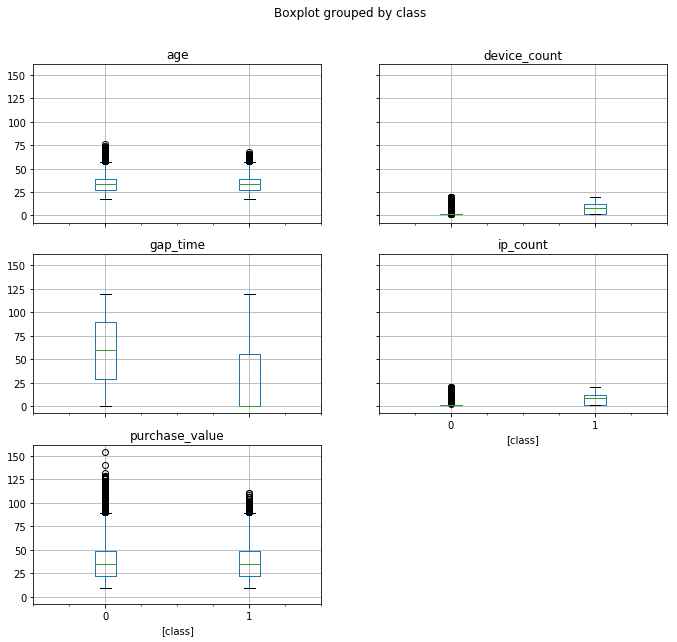

In [35]:
data[["purchase_value", "age", "gap_time", "device_count", "ip_count", "class"]].boxplot(by = "class", figsize = [11, 10])

class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: purchase_value, dtype: object

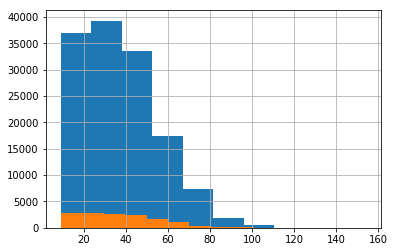

In [44]:
data.groupby(["class"])["purchase_value"].hist()

class
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: purchase_value, dtype: object

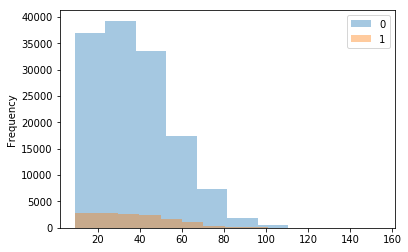

In [52]:
data.groupby(["class"])["purchase_value"].plot(kind = "hist", legend = True, alpha = 0.4)

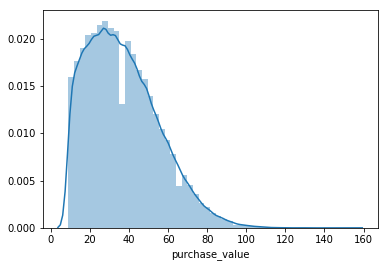

In [55]:
sns.distplot(data["purchase_value"])

In [56]:
data.describe()

,purchase_value,age,ip_address,class,gap_time,device_count,ip_count
count,151112.000000,151112.000000,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000
mean,36.935372,33.140704,2.152145e+09,0.093646,56.609799,1.684367,1.602719
std,18.322762,8.617733,1.248497e+09,0.291336,36.142085,2.616954,2.596240
min,9.000000,18.000000,5.209350e+04,0.000000,0.000000,1.000000,1.000000
25%,22.000000,27.000000,1.085934e+09,0.000000,25.000000,1.000000,1.000000
50%,35.000000,33.000000,2.154770e+09,0.000000,57.000000,1.000000,1.000000
75%,49.000000,39.000000,3.243258e+09,0.000000,88.000000,1.000000,1.000000
max,154.000000,76.000000,4.294850e+09,1.000000,119.000000,20.000000,20.000000


### Random Forest

In [57]:
data.head(2)

,purchase_value,source,browser,sex,age,ip_address,class,country,gap_time,device_count,ip_count
0,34,SEO,Chrome,M,39,7.327584e+08,0,Japan,52,1,1
1,16,Ads,Chrome,F,53,3.503114e+08,0,United States,0,1,1


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [59]:
df = pd.get_dummies(data, drop_first = True)

In [60]:
train, test = train_test_split(df, test_size = 0.34)

In [62]:
clt = RandomForestClassifier(n_estimators=100, max_features = 3, oob_score = True)
clt.fit(train.drop(["class"], axis = 1), train["class"])

RandomForestClassifier(max_features=3, oob_score=True)

In [63]:
clt.predict(test.drop(["class"], axis = 1))

array([0, 0, 0, ..., 0, 0, 0])

In [64]:
clt.score(test.drop(["class"], axis = 1), test["class"])

0.9569863173670177

### Model Metrics

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [68]:
pd.DataFrame(confusion_matrix(test["class"], clt.predict(test.drop(["class"], axis = 1)), labels = [0, 1]))

,0,1
0,46555,22
1,2188,2614


In [70]:
pred_prob = clt.predict_proba(test.drop(["class"], axis = 1))[:, 1]
pred_prob

array([0.01, 0.  , 0.34, ..., 0.  , 0.03, 0.05])

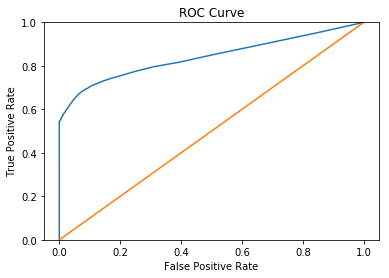

In [75]:
fpr, tpr, thresholds = roc_curve(test["class"], pred_prob)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.ylim([0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

### Feature Importance
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

In [76]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer

In [77]:
data.head(2)

,purchase_value,source,browser,sex,age,ip_address,class,country,gap_time,device_count,ip_count
0,34,SEO,Chrome,M,39,7.327584e+08,0,Japan,52,1,1
1,16,Ads,Chrome,F,53,3.503114e+08,0,United States,0,1,1


In [80]:
y = data["class"]
categorical = ["source", "browser", "sex", "country"]
numerical = ["purchase_value", "age", "ip_address", "device_count", "ip_count", "gap_time"]
X = data[categorical + numerical]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [81]:
categorical_encoder = OneHotEncoder(handle_unknown = "ignore")
numerical_encoder = Pipeline([('imputer', SimpleImputer(strategy = "mean"))])
preprocessing = ColumnTransformer([('cat', categorical_encoder, categorical),
                                  ('num', numerical_encoder, numerical)])

In [82]:
rf = Pipeline([('preprocess', preprocessing),
              ('classifier', RandomForestClassifier(n_estimators= 500, class_weight = 'balanced', random_state = 42))])
rf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['source', 'browser', 'sex',
                                                   'country']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['purchase_value', 'age',
                                                   'ip_address', 'device_count',
                                                   'ip_count', 'gap_time'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, random_state=42))])

In [91]:
ohe = (rf.named_steps["preprocess"].named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features = categorical)
feature_names = np.r_[feature_names, numerical]

In [101]:
feature_importance = rf.named_steps["classifier"].feature_importances_
feature_imp_index = rf.named_steps["classifier"].feature_importances_.argsort() 

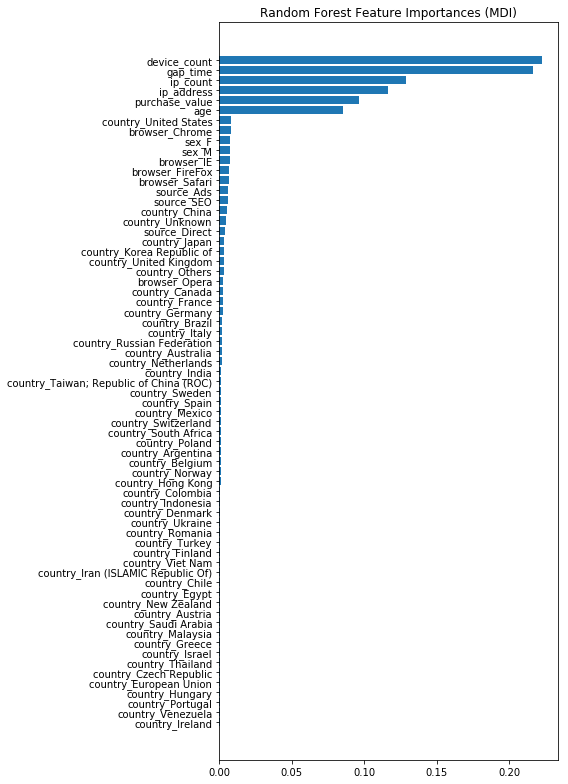

In [112]:
y_tick = np.arange(0, len(feature_imp_index))
fig, ax = plt.subplots(figsize = [8, 11])
ax.barh(y_tick, feature_importance[feature_imp_index])
ax.set_yticks(y_tick)
ax.set_yticklabels(feature_names[feature_imp_index])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [95]:
sorted_ind = rf.named_steps["classifier"].feature_importances_.argsort()

array([32, 59, 44, 28, 22, 19, 53, 33, 26, 37, 47, 12, 40, 21, 16, 31, 60,
       23, 54, 45, 55, 20, 30, 18, 27, 41, 13, 10, 43, 48, 51, 38, 49, 50,
       52, 29, 39, 11, 46, 34, 14, 25, 24, 15,  6, 42, 56, 36, 35,  1, 58,
       17,  2,  0,  7,  4,  5,  9,  8,  3, 57, 62, 61, 63, 65, 66, 64])

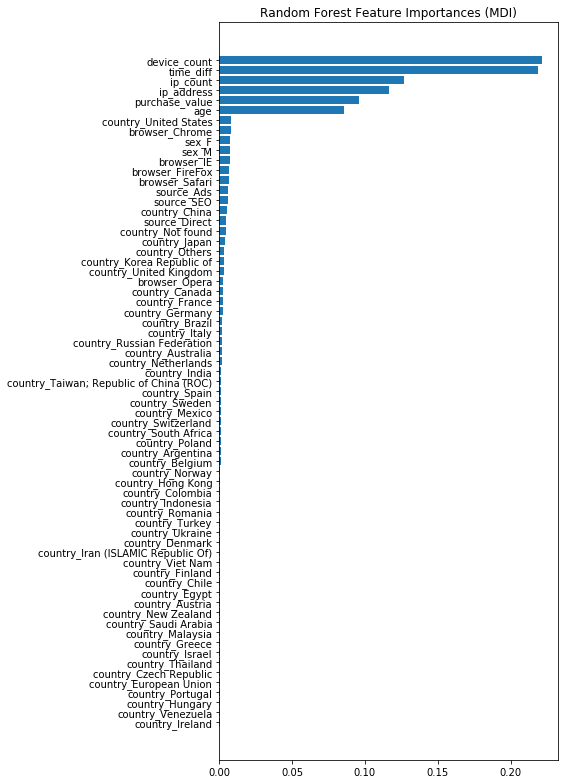

In [128]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=categorical_cols)
feature_names = np.r_[feature_names, numerical_cols]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize = (8, 11))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

In [129]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

exception calling callback for <Future at 0x7f862b3365f8 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/eve/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/Users/eve/anaconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/Users/eve/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py", line 524, in load_temporary_memmap
    obj = load(filename, mmap_mode)
  File "/Users/eve/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py", line 585, in load
    obj = _unpickle(fobj, filename, mmap_mode)
  File "/Users/eve/anaconda3/lib/python3.7/site-packages/joblib/numpy_pickle.py", line 504, in _unpickle
    obj = unpickler.load()
  File "/Users/eve/anaconda3/lib/python3.7/pickle.py", li

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Decision Tree

In [120]:
data.head(2)

,purchase_value,source,browser,sex,age,ip_address,class,country,device_count,ip_count,time_diff
0,34,SEO,Chrome,M,39,7.327584e+08,0,Japan,1,1,52
1,16,Ads,Chrome,F,53,3.503114e+08,0,United States,1,1,0


In [121]:
#1. Prepare data
data_dummy = pd.get_dummies(data, drop_first=True)
training_cols = data_dummy.drop(['class'], axis = 1)

In [125]:
#2. Modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source

dt = DecisionTreeClassifier(class_weight = 'balanced', min_impurity_decrease = 0.001)
dt.fit(training_cols, data_dummy['class'])

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [126]:
#3. Draw decision tree plot
export_graphviz(dt, out_file = 'tree.dot', feature_names = training_cols.columns, proportion = True)
s = graphviz.Source.from_file("tree.dot")
s.view()

'tree.dot.pdf'

### Linear Regression

In [131]:
#1. Prepare data
y = data["class"].astype('int')
X = data[['purchase_value', 'age', 'device_count', 'ip_count', 'time_diff']]

In [132]:
#2. Modeling
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.score(X, y) # the coefficient of determination R^2 of the prediction

0.45375971783940916

In [133]:
reg.coef_

array([-2.46808416e-05, -4.54253745e-05,  1.13450608e-01, -4.09824120e-02,
       -3.36015241e-04])

In [134]:
reg.intercept_

-0.010324586713217385

In [135]:
reg.predict(np.array([[0, 30, 50, 20, 30]]))

array([4.83111434])

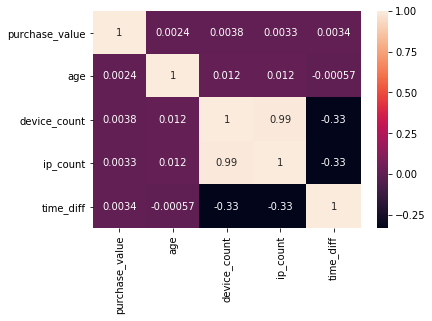

In [137]:
import seaborn as sns
corr = X.corr()
sns.heatmap(corr, annot = True)